In [1]:
# from erddapy import ERDDAP
import cmocean as cmo
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime
from scipy import interpolate
import scipy
import pandas as pd
import metpy.calc as mc
import xarray as xr
import pyproj


In [2]:
def get_ticks(bounds, dirs, otherbounds):
    dirs = dirs.lower()
    l0 = np.float(bounds[0])
    l1 = np.float(bounds[1])
    r = np.max([l1 - l0, np.float(otherbounds[1]) - np.float(otherbounds[0])])
    if r <= 1.5:
        # <1.5 degrees: 15' major ticks, 5' minor ticks
        minor_int = 1.0 / 12.0
        major_int = 1.0 / 4.0
    elif r <= 3.0:
        # <3 degrees: 30' major ticks, 10' minor ticks
        minor_int = 1.0 / 6.0
        major_int = 0.5
    elif r <= 7.0:
        # <7 degrees: 1d major ticks, 15' minor ticks
        minor_int = 0.25
        major_int = np.float(1)
    elif r <= 15:
        # <15 degrees: 2d major ticks, 30' minor ticks
        minor_int = 0.5
        major_int = np.float(2)
    elif r <= 30:
        # <30 degrees: 3d major ticks, 1d minor ticks
        minor_int = np.float(1)
        major_int = np.float(3)
    else:
        # >=30 degrees: 5d major ticks, 1d minor ticks
        minor_int = np.float(1)
        major_int = np.float(5)

    minor_ticks = np.arange(np.ceil(l0 / minor_int) * minor_int, np.ceil(l1 / minor_int) * minor_int + minor_int,
                            minor_int)
    minor_ticks = minor_ticks[minor_ticks <= l1]
    major_ticks = np.arange(np.ceil(l0 / major_int) * major_int, np.ceil(l1 / major_int) * major_int + major_int,
                            major_int)
    major_ticks = major_ticks[major_ticks <= l1]

    if major_int < 1:
        d, m, s = dd2dms(np.array(major_ticks))
        if dirs == 'we' or dirs == 'ew' or dirs == 'lon' or dirs == 'long' or dirs == 'longitude':
            n = 'W' * sum(d < 0)
            p = 'E' * sum(d >= 0)
            dir = n + p
            major_tick_labels = [str(np.abs(int(d[i]))) + u"\N{DEGREE SIGN}" + str(int(m[i])) + "'" + dir[i] for i in
                                 range(len(d))]
        elif dirs == 'sn' or dirs == 'ns' or dirs == 'lat' or dirs == 'latitude':
            n = 'S' * sum(d < 0)
            p = 'N' * sum(d >= 0)
            dir = n + p
            major_tick_labels = [str(np.abs(int(d[i]))) + u"\N{DEGREE SIGN}" + str(int(m[i])) + "'" + dir[i] for i in
                                 range(len(d))]
        else:
            major_tick_labels = [str(int(d[i])) + u"\N{DEGREE SIGN}" + str(int(m[i])) + "'" for i in range(len(d))]
    else:
        d = major_ticks
        if dirs == 'we' or dirs == 'ew' or dirs == 'lon' or dirs == 'long' or dirs == 'longitude':
            n = 'W' * sum(d < 0)
            p = 'E' * sum(d >= 0)
            dir = n + p
            major_tick_labels = [str(np.abs(int(d[i]))) + u"\N{DEGREE SIGN}" + dir[i] for i in range(len(d))]
        elif dirs == 'sn' or dirs == 'ns' or dirs == 'lat' or dirs == 'latitude':
            n = 'S' * sum(d < 0)
            p = 'N' * sum(d >= 0)
            dir = n + p
            major_tick_labels = [str(np.abs(int(d[i]))) + u"\N{DEGREE SIGN}" + dir[i] for i in range(len(d))]
        else:
            major_tick_labels = [str(int(d[i])) + u"\N{DEGREE SIGN}" for i in range(len(d))]

    return minor_ticks, major_ticks, major_tick_labels

In [3]:
def add_map_features(ax, extent):
#     # Gridlines and grid labels
#     gl = ax.gridlines(
#         draw_labels=True,
#         linewidth=.5,
#         color='black',
#         alpha=0.25,
#         linestyle='--',
#     )

#     gl.xlabels_top = gl.ylabels_right = False
#     gl.xlabel_style = {'size': 16, 'color': 'black'}
#     gl.ylabel_style = {'size': 16, 'color': 'black'}

#     gl.xformatter = LONGITUDE_FORMATTER
#     gl.yformatter = LATITUDE_FORMATTER

    xl = [extent[0], extent[1]]
    yl = [extent[2], extent[3]]

    tick0x, tick1, ticklab = get_ticks(xl, 'we', yl)
    ax.set_xticks(tick0x, minor=True, crs=ccrs.PlateCarree())
    ax.set_xticks(tick1, crs=ccrs.PlateCarree())
    ax.set_xticklabels(ticklab, fontsize=14)

    # get and add latitude ticks/labels
    tick0y, tick1, ticklab = get_ticks(yl, 'sn', xl)
    ax.set_yticks(tick0y, minor=True, crs=ccrs.PlateCarree())
    ax.set_yticks(tick1, crs=ccrs.PlateCarree())
    ax.set_yticklabels(ticklab, fontsize=14)

    gl = ax.gridlines(draw_labels=False, linewidth=.5, color='gray', alpha=0.75, linestyle='--', crs=ccrs.PlateCarree())
    gl.xlocator = mticker.FixedLocator(tick0x)
    gl.ylocator = mticker.FixedLocator(tick0y)

    ax.tick_params(which='major',
                   direction='out',
                   bottom=True, top=True,
                   labelbottom=True, labeltop=False,
                   left=True, right=True,
                   labelleft=True, labelright=False,
                   length=5, width=2)

    ax.tick_params(which='minor',
                   direction='out',
                   bottom=True, top=True,
                   labelbottom=True, labeltop=False,
                   left=True, right=True,
                   labelleft=True, labelright=False,
                   width=1)

    # Axes properties and features
    ax.set_extent(extent)
    ax.add_feature(LAND, zorder=0, edgecolor='black')
    ax.add_feature(cfeature.LAKES)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(state_lines, edgecolor='black')
    return ax

In [4]:
file = 'C:/users/fishp/software_bootcamp_2021/Thesis/HFR_Data/202107181000_hfr_usegc_2km_rtv_uwls_NDBC.nc'
ds = xr.open_dataset(file)
ds

<xarray.Dataset>
Dimensions:                (lat: 1380, lon: 2103, nv: 2, time: 1)
Coordinates:
  * time                   (time) datetime64[ns] 2021-07-18T10:00:00
  * lat                    (lat) float32 21.7 21.71798 ... 46.47644 46.49442
  * lon                    (lon) float32 -97.88385 -97.864494 ... -57.192493
    depth                  float32 ...
Dimensions without coordinates: nv
Data variables:
    time_bnds              (time, nv) datetime64[ns] ...
    depth_bnds             (nv) float32 ...
    wgs84                  int8 ...
    u                      (time, lat, lon) float32 ...
    v                      (time, lat, lon) float32 ...
    dopx                   (time, lat, lon) float32 ...
    dopy                   (time, lat, lon) float32 ...
    hdop                   (time, lat, lon) float32 ...
    number_of_sites        (time, lat, lon) float32 ...
    number_of_radials      (time, lat, lon) float32 ...
    processing_parameters  int8 ...
    radial_metadata        int8 ...
Attributes:
    Conventions:               ACDD-1.3,CF-1.7
    id:                        202107181000ndbchfruwlsrtvusegc2km
    date_created:              2021-07-18T12:51:48Z
    source:                    surface ocean velocity field from hf-radar
    program:                   Integrated Ocean Observing System (IOOS)
    title:                     Near-Real Time Surface Ocean Velocity, U.S. Ea...
    summary:                   Surface ocean velocities estimated from HF-Rad...
    instrument:                Earth Remote Sensing Instruments, Active Remot...
    keywords:                  Earth Science, Oceans, Sea Surface, Coastal Pr...
    geospatial_lat_min:        21.7
    geospatial_lat_max:        46.49442
    geospatial_lon_min:        -97.88385
    geospatial_lon_max:        -57.192493
    processing_level:          Near real-time dataset with automated data acq...
    history:                   2021-07-18T10:51:28Z hfrnet rtvMergeData: Savi...
    references:                Terrill, E. et al., 2006. Data Management and ...
    institution:               National Data Buoy Center
    creator_type:              group
    creator_name:              NDBC Webmaster
    creator_email:             webmaster.ndbc@noaa.gov
    creator_url:               https://hfradar.ndbc.noaa.gov
    naming_authority:          gov.noaa.ndbc
    standard_name_vocabulary:  CF Standard Name Table, Version 51
    keywords_vocabulary:       Global Change Master Directory (GCMD) Keywords...
    instrument_vocabulary:     Global Change Master Directory (GCMD) Keywords...
    format_version:            1.1.00
    product_version:           2.0.00

In [5]:
lon = ds['lon']
lat = ds['lat']
u = ds['u']
v= ds['v']

In [6]:
region = ds.sel(lon=slice(-75.5, -74), lat=slice(38.5, 39.25))
region

<xarray.Dataset>
Dimensions:                (lat: 42, lon: 77, nv: 2, time: 1)
Coordinates:
  * time                   (time) datetime64[ns] 2021-07-18T10:00:00
  * lat                    (lat) float32 38.5113 38.52928 ... 39.2305 39.24848
  * lon                    (lon) float32 -75.48618 -75.46682 ... -74.014946
    depth                  float32 0.55
Dimensions without coordinates: nv
Data variables:
    time_bnds              (time, nv) datetime64[ns] 2021-07-18T09:30:00 2021...
    depth_bnds             (nv) float32 0.0 1.0
    wgs84                  int8 -127
    u                      (time, lat, lon) float32 ...
    v                      (time, lat, lon) float32 ...
    dopx                   (time, lat, lon) float32 ...
    dopy                   (time, lat, lon) float32 ...
    hdop                   (time, lat, lon) float32 ...
    number_of_sites        (time, lat, lon) float32 ...
    number_of_radials      (time, lat, lon) float32 ...
    processing_parameters  int8 -127
    radial_metadata        int8 -127
Attributes:
    Conventions:               ACDD-1.3,CF-1.7
    id:                        202107181000ndbchfruwlsrtvusegc2km
    date_created:              2021-07-18T12:51:48Z
    source:                    surface ocean velocity field from hf-radar
    program:                   Integrated Ocean Observing System (IOOS)
    title:                     Near-Real Time Surface Ocean Velocity, U.S. Ea...
    summary:                   Surface ocean velocities estimated from HF-Rad...
    instrument:                Earth Remote Sensing Instruments, Active Remot...
    keywords:                  Earth Science, Oceans, Sea Surface, Coastal Pr...
    geospatial_lat_min:        21.7
    geospatial_lat_max:        46.49442
    geospatial_lon_min:        -97.88385
    geospatial_lon_max:        -57.192493
    processing_level:          Near real-time dataset with automated data acq...
    history:                   2021-07-18T10:51:28Z hfrnet rtvMergeData: Savi...
    references:                Terrill, E. et al., 2006. Data Management and ...
    institution:               National Data Buoy Center
    creator_type:              group
    creator_name:              NDBC Webmaster
    creator_email:             webmaster.ndbc@noaa.gov
    creator_url:               https://hfradar.ndbc.noaa.gov
    naming_authority:          gov.noaa.ndbc
    standard_name_vocabulary:  CF Standard Name Table, Version 51
    keywords_vocabulary:       Global Change Master Directory (GCMD) Keywords...
    instrument_vocabulary:     Global Change Master Directory (GCMD) Keywords...
    format_version:            1.1.00
    product_version:           2.0.00

In [7]:
lons = region['lon']
lats = region['lat']
us = region['u']
vs = region['v']

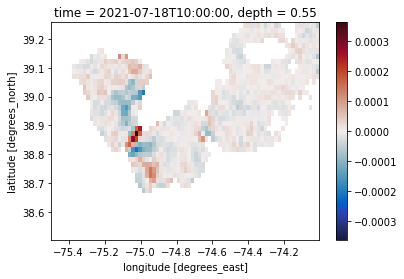

In [8]:
div=mc.divergence(us,vs)
div.plot(cmap=cmo.cm.balance)

In [9]:
projection = ccrs.PlateCarree()

extent = [
    -75.5,
    -74.75,
    38.5,
    39.25
]

LAND = cfeature.NaturalEarthFeature(
    'physical', 'land', '10m',
    edgecolor='face',
    facecolor='tan'
)

state_lines = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none'
)

C:\Users\Fishp\anaconda3\envs\Thesis\lib\site-packages\cartopy\crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\Fishp\anaconda3\envs\Thesis\lib\site-packages\cartopy\crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\Fishp\anaconda3\envs\Thesis\lib\site-packages\cartopy\crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
C:\Users\Fishp\anaconda3\envs\Thesis\lib\site-packages\cartop

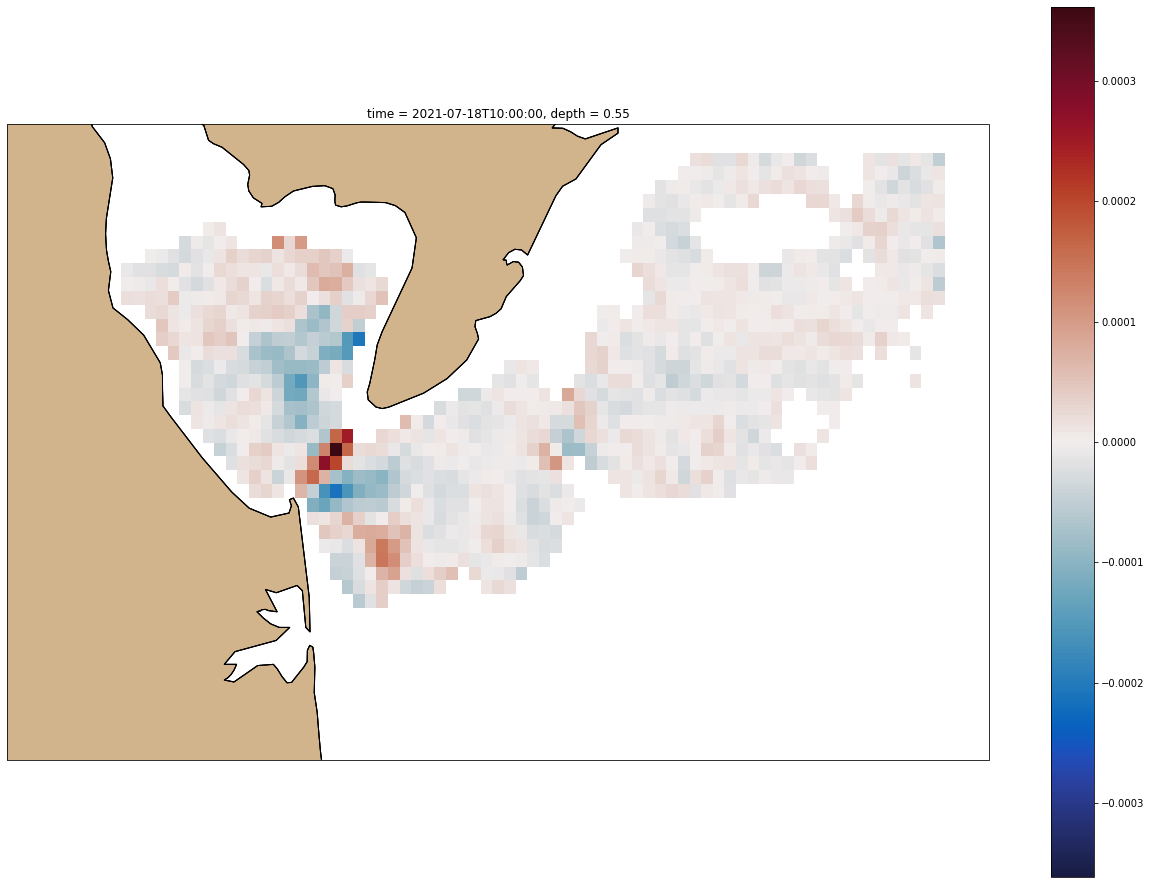

In [10]:
fig, ax = plt.subplots(
    figsize=(22, 16),
    subplot_kw=dict(projection=ccrs.Mercator())
)

div.plot(cmap=cmo.cm.balance, zorder=10,transform=ccrs.PlateCarree())
# add_map_features(ax, extent)
ax.coastlines()
ax.add_feature(cfeature.STATES)
ax.add_feature(LAND, zorder=0, edgecolor='black')

In [11]:
dss=region
lonz = dss['lon']
latz = dss['lat']
uz = dss['u']
vz = dss['v']

In [12]:
dss

<xarray.Dataset>
Dimensions:                (lat: 42, lon: 77, nv: 2, time: 1)
Coordinates:
  * time                   (time) datetime64[ns] 2021-07-18T10:00:00
  * lat                    (lat) float32 38.5113 38.52928 ... 39.2305 39.24848
  * lon                    (lon) float32 -75.48618 -75.46682 ... -74.014946
    depth                  float32 0.55
Dimensions without coordinates: nv
Data variables:
    time_bnds              (time, nv) datetime64[ns] 2021-07-18T09:30:00 2021...
    depth_bnds             (nv) float32 0.0 1.0
    wgs84                  int8 -127
    u                      (time, lat, lon) float32 nan nan nan ... 0.07 0.07
    v                      (time, lat, lon) float32 nan nan nan ... -0.08 -0.07
    dopx                   (time, lat, lon) float32 nan nan ... 0.59999996
    dopy                   (time, lat, lon) float32 nan nan nan ... 0.64 0.57
    hdop                   (time, lat, lon) float32 nan nan nan ... 0.84 0.83
    number_of_sites        (time, lat, lon) float32 nan nan nan ... 3.0 3.0 3.0
    number_of_radials      (time, lat, lon) float32 nan nan nan ... 6.0 7.0 7.0
    processing_parameters  int8 -127
    radial_metadata        int8 -127
Attributes:
    Conventions:               ACDD-1.3,CF-1.7
    id:                        202107181000ndbchfruwlsrtvusegc2km
    date_created:              2021-07-18T12:51:48Z
    source:                    surface ocean velocity field from hf-radar
    program:                   Integrated Ocean Observing System (IOOS)
    title:                     Near-Real Time Surface Ocean Velocity, U.S. Ea...
    summary:                   Surface ocean velocities estimated from HF-Rad...
    instrument:                Earth Remote Sensing Instruments, Active Remot...
    keywords:                  Earth Science, Oceans, Sea Surface, Coastal Pr...
    geospatial_lat_min:        21.7
    geospatial_lat_max:        46.49442
    geospatial_lon_min:        -97.88385
    geospatial_lon_max:        -57.192493
    processing_level:          Near real-time dataset with automated data acq...
    history:                   2021-07-18T10:51:28Z hfrnet rtvMergeData: Savi...
    references:                Terrill, E. et al., 2006. Data Management and ...
    institution:               National Data Buoy Center
    creator_type:              group
    creator_name:              NDBC Webmaster
    creator_email:             webmaster.ndbc@noaa.gov
    creator_url:               https://hfradar.ndbc.noaa.gov
    naming_authority:          gov.noaa.ndbc
    standard_name_vocabulary:  CF Standard Name Table, Version 51
    keywords_vocabulary:       Global Change Master Directory (GCMD) Keywords...
    instrument_vocabulary:     Global Change Master Directory (GCMD) Keywords...
    format_version:            1.1.00
    product_version:           2.0.00

In [13]:
dz=dss.squeeze()
dz

<xarray.Dataset>
Dimensions:                (lat: 42, lon: 77, nv: 2)
Coordinates:
    time                   datetime64[ns] 2021-07-18T10:00:00
  * lat                    (lat) float32 38.5113 38.52928 ... 39.2305 39.24848
  * lon                    (lon) float32 -75.48618 -75.46682 ... -74.014946
    depth                  float32 0.55
Dimensions without coordinates: nv
Data variables:
    time_bnds              (nv) datetime64[ns] 2021-07-18T09:30:00 2021-07-18...
    depth_bnds             (nv) float32 0.0 1.0
    wgs84                  int8 -127
    u                      (lat, lon) float32 nan nan nan nan ... 0.01 0.07 0.07
    v                      (lat, lon) float32 nan nan nan ... -0.08 -0.07
    dopx                   (lat, lon) float32 nan nan ... 0.53999996 0.59999996
    dopy                   (lat, lon) float32 nan nan nan ... 0.64 0.57
    hdop                   (lat, lon) float32 nan nan nan ... 0.84 0.83
    number_of_sites        (lat, lon) float32 nan nan nan nan ... 3.0 3.0 3.0
    number_of_radials      (lat, lon) float32 nan nan nan nan ... 6.0 7.0 7.0
    processing_parameters  int8 -127
    radial_metadata        int8 -127
Attributes:
    Conventions:               ACDD-1.3,CF-1.7
    id:                        202107181000ndbchfruwlsrtvusegc2km
    date_created:              2021-07-18T12:51:48Z
    source:                    surface ocean velocity field from hf-radar
    program:                   Integrated Ocean Observing System (IOOS)
    title:                     Near-Real Time Surface Ocean Velocity, U.S. Ea...
    summary:                   Surface ocean velocities estimated from HF-Rad...
    instrument:                Earth Remote Sensing Instruments, Active Remot...
    keywords:                  Earth Science, Oceans, Sea Surface, Coastal Pr...
    geospatial_lat_min:        21.7
    geospatial_lat_max:        46.49442
    geospatial_lon_min:        -97.88385
    geospatial_lon_max:        -57.192493
    processing_level:          Near real-time dataset with automated data acq...
    history:                   2021-07-18T10:51:28Z hfrnet rtvMergeData: Savi...
    references:                Terrill, E. et al., 2006. Data Management and ...
    institution:               National Data Buoy Center
    creator_type:              group
    creator_name:              NDBC Webmaster
    creator_email:             webmaster.ndbc@noaa.gov
    creator_url:               https://hfradar.ndbc.noaa.gov
    naming_authority:          gov.noaa.ndbc
    standard_name_vocabulary:  CF Standard Name Table, Version 51
    keywords_vocabulary:       Global Change Master Directory (GCMD) Keywords...
    instrument_vocabulary:     Global Change Master Directory (GCMD) Keywords...
    format_version:            1.1.00
    product_version:           2.0.00

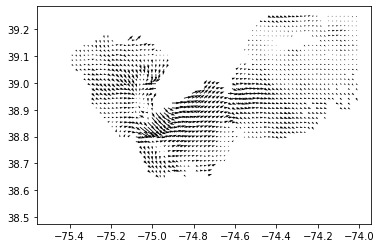

In [16]:
plt.quiver(dz['lon'], dz['lat'], dz['u'], dz['v'])

In [17]:
# fig, ax = plt.subplots(figsize=(22, 16))
# plt.quiver(dz['lon'], dz['lat'], dz['u'], dz['v'],transform=ccrs.Mercator())
# ax.coastlines()
# ax.add_feature(cfeature.STATES)
# ax.add_feature(LAND, zorder=0, edgecolor='black')

In [19]:
ax = fig.add_subplot(111,projection=ccrs.Mercator())
ax.quiver(dz['lon'], dz['lat'], dz['u'], dz['v'],transform=ccrs.PlateCarree(),ax=ax)
ax.coastlines()
ax.add_feature(cfeature.STATES)
ax.add_feature(LAND, zorder=0, edgecolor='black')

TypeError: Argument 'x' has incorrect type (expected numpy.ndarray, got DataArray)

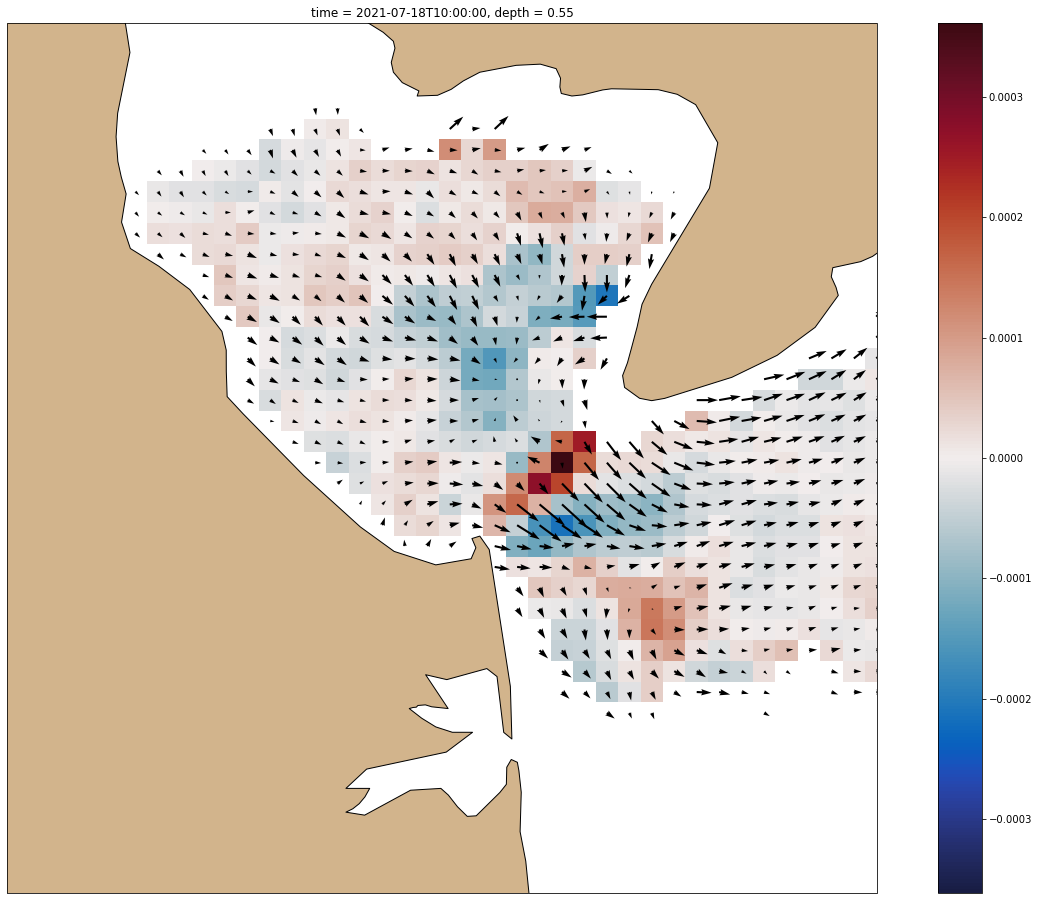

In [20]:
fig, ax = plt.subplots(
    figsize=(22, 16),
    subplot_kw=dict(projection=ccrs.PlateCarree())
)

# plot arrows over pcolor
h = ax.quiver(
    dz['lon'], 
    dz['lat'], 
    dz['u'], 
    dz['v'],
    transform=ccrs.PlateCarree(),
    zorder=20
)

div.plot(cmap=cmo.cm.balance,zorder=10,transform=ccrs.PlateCarree())

ax.set_extent(extent)
ax.add_feature(LAND, zorder=0, edgecolor='black')
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(state_lines, edgecolor='black')